# Notes on strain rate and velocity calculation


In [1]:
%load_ext autoreload
%autoreload 2 
import hvplot.xarray

import sys
sys.path.append("../../../xapres/")
import xapres as xa
import matplotlib.pyplot as plt
import xarray as xr
from datatree import DataTree
import numpy as np

In [14]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})
LTG = load_zarr('/Users/jkingslake/Documents/science/ApRES/TG_apres/notebooks/zarrs/LTG_stacked.zarr').load()
dLTG = LTG.profile_stacked.displacement_timeseries().compute()

## Compute the time deifference between shot and the preceeding shot

In [15]:
dt_years = ((dLTG.profile_time.sel(shot_number=2) - dLTG.profile_time.sel(shot_number=1)) / np.timedelta64(1,'D') / 365.25).rename('dt_years')
dt_years.attrs['units'] = 'years'
dt_years.attrs['long_name'] = 'Time between shots'
dt_years.attrs['description'] = 'Time in years between shots used in each measurement of displacement, vertical velocity, etc. dt_years[i] is the time between shot [j] and shot [j-1]'

## Calculate the velocity

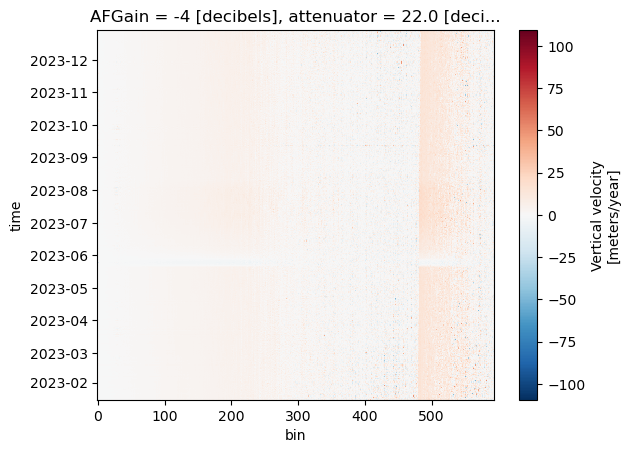

In [16]:
velocity = (dLTG.displacement / dt_years).rename('velocity')
velocity.attrs['units'] = 'meters/year'
velocity.attrs['long_name'] = 'Vertical velocity'
velocity.plot()

## Use a linear fit to calculate the vertical strian rate

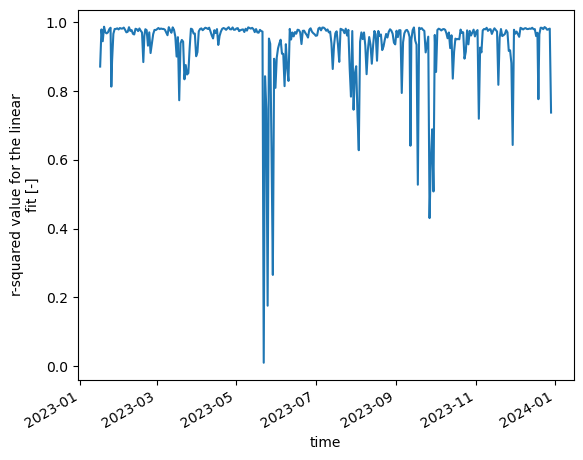

In [17]:
def addStrainRates(self, lower_limit_on_fit = 800):
    data_cropped = self.velocity\
            .squeeze()\
            .where(self.velocity.bin_depth < lower_limit_on_fit)
    
    fit_ds = data_cropped.polyfit('bin', 1, full = True)
            
    strain_rate = fit_ds.sel(degree = 1, drop =True).polyfit_coefficients.rename('strain_rate')
    surface_intercept =  fit_ds.sel(degree = 0, drop =True).polyfit_coefficients.rename('surface_intercept') 

    strain_rate.attrs['units'] = '1/year'
    strain_rate.attrs['long_name'] = f"vertical strain rate in upper {lower_limit_on_fit} m"
    surface_intercept.attrs['units'] = 'meters/year'
    surface_intercept.attrs['long_name'] = 'vertical velocity at the surface from the linear fit'
    
    y_mean = data_cropped.mean(dim = 'bin')
    SS_tot = ((data_cropped - y_mean)**2).sum(dim = 'bin')
    R2 = (1 - (fit_ds.polyfit_residuals/SS_tot)).rename('r_squared')
    R2.attrs['long_name'] = 'r-squared value for the linear fit'
    R2.attrs['units'] = '-'   
    
    return xr.merge([self, strain_rate, surface_intercept, R2])


xr.Dataset.addStrainRates = addStrainRates

dLTG_ezz = xr.merge([dLTG, velocity]).addStrainRates()
dLTG_ezz.r_squared.plot()

## Test implementaiton in xapres.utils

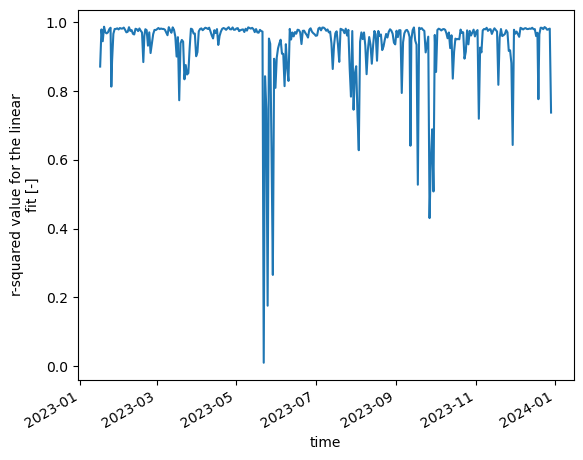

In [18]:
dLTG = LTG.profile_stacked.displacement_timeseries().compute()
dLTG.r_squared.plot()

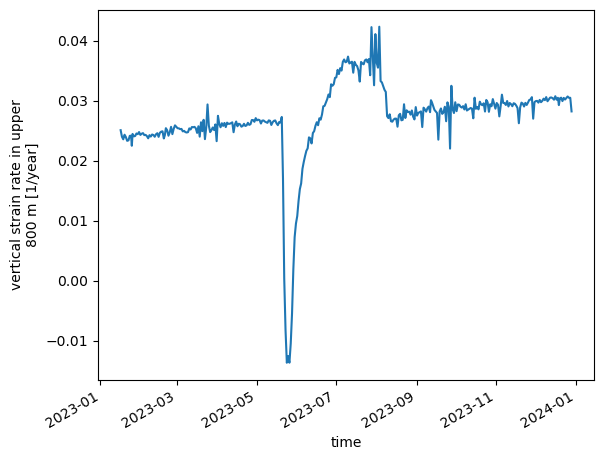

In [19]:
dLTG.strain_rate.plot()

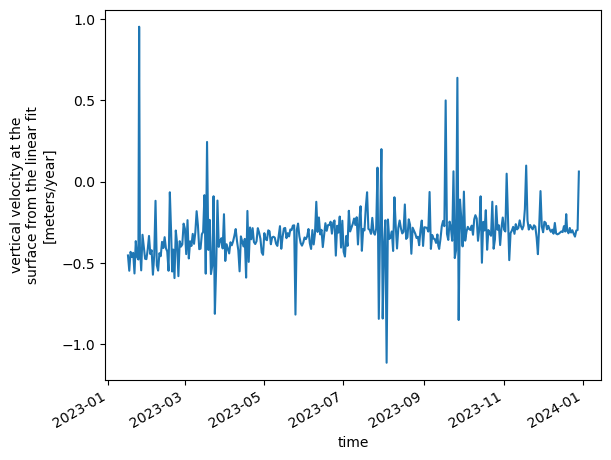

In [20]:
dLTG.surface_intercept.plot()

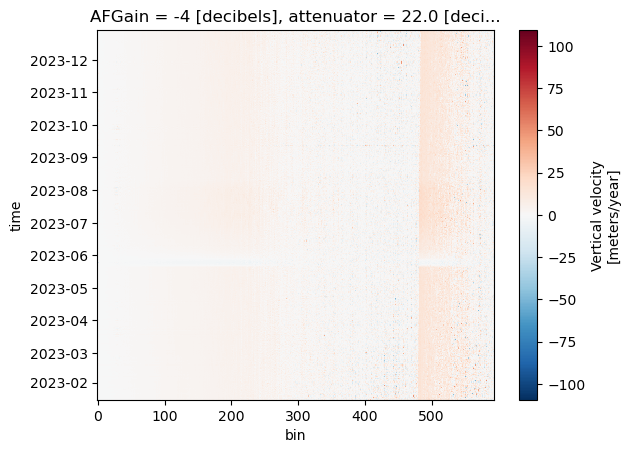

In [21]:
dLTG.velocity.plot()